In [12]:
%matplotlib inline

In [139]:
import pandas as pd

io_params = {
    'parse_dates': ['epoch']
}

data = pd.concat(
    (
        pd.read_csv('data/IDAO 2020/train.csv', **io_params),
        pd.read_csv('data/IDAO 2020/Track 1/test.csv', **io_params)
    ),
    sort=False
)
data['is_train'] = data['x'].notnull()
data = data.sort_values(['sat_id', 'epoch'])
data['is_test_sat'] = data['sat_id'].isin(data.query('not is_train')['sat_id'].unique())

Remove weird looking satellites.

In [140]:
blacklist = (56, 66, 202, 224, 554)
data = data.query('sat_id not in @blacklist')
assert len(data.query('not is_train') == 284_071)  # Check no test rows are dropped

Round the epoch in order to find the duplicates and put them aside.

In [141]:
data['epoch_rounded'] = data['epoch'].dt.round('min')  # Round to the minute
data['is_duplicate'] = data.duplicated(['sat_id', 'epoch_rounded']).to_numpy()
duplicates = data.query('is_duplicate')
data = data.query('not is_duplicate')

Add cycle index.

In [142]:
data['cycle_index'] = data.groupby('sat_id').apply(lambda g: pd.Series(pd.np.arange(len(g)) % 24)).to_numpy()

Add cycle number.

In [143]:
data['cycle_no'] = data.groupby('sat_id').apply(lambda g: pd.Series(pd.np.arange(len(g)) // 24)).to_numpy()

Add UNIX timestamp.

In [144]:
data['unix'] = data['epoch'].astype(pd.np.int64) // 10e9 / 10e6

Implement SMAPE.

In [145]:
import numpy as np

def smape(y_true, y_pred): 
    return np.mean(np.abs((y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true))))

**TODO: define fit and val earlier on**

In [146]:
import functools
from numpy import polynomial
import tqdm

preds = []

def poly_1d(x, a, b):
    return a + b * x


for (sat, idx), g in tqdm.tqdm(data.groupby(['sat_id', 'cycle_index'])):
    
    train = g[g['is_train']]
    cut_point = len(train) // 2 + 1
    fit = train[:cut_point]
    val = train[cut_point:]
    test = g[~g['is_train']]
    
    for col in ('x', 'y', 'z', 'Vx', 'Vy', 'Vz'):
        
        #coeffs, _ = optimize.curve_fit(poly_1d, xdata=fit['unix'], ydata=fit['x'])
        #pred = poly_1d(val['unix'], *coeffs)
        
        #poly = polynomial.Polynomial.fit(fit['unix'], fit['x'], deg=1)
        #pred = poly(val['unix'])
        
        poly = pd.np.polyfit(x=fit['unix'], y=fit[col], deg=2)
        pred = functools.reduce(np.add, (coeff * val['unix'] ** i for i, coeff in enumerate(reversed(poly))))
        
        preds.append(pd.DataFrame({
            'sat_id': sat,
            'epoch': val['epoch'],
            'cycle_index': idx,
            'y_true': val[col],
            'y_pred': pred,
            'target': col
        }))
        
preds = pd.concat(preds)

 42%|████▏     | 5974/14280 [02:04<02:42, 51.17it/s]/home/max/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3296: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/max/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3296: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/max/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3296: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/max/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3296: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/max/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3296: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/max/anaconda

In [147]:
sat_smapes = preds.groupby('sat_id').apply(lambda g: smape(g['y_true'], g['y_pred']))
mean_smape = sat_smapes.mean()
100 * (1 - mean_smape)

96.29581192358081

95.37

# ~~~

In [135]:
sat_smapes.sort_values(ascending=False).head(10)

sat_id
37     0.781003
372    0.770408
249    0.725060
587    0.723423
523    0.694726
514    0.673835
473    0.599283
253    0.537392
429    0.511100
478    0.492735
dtype: float64

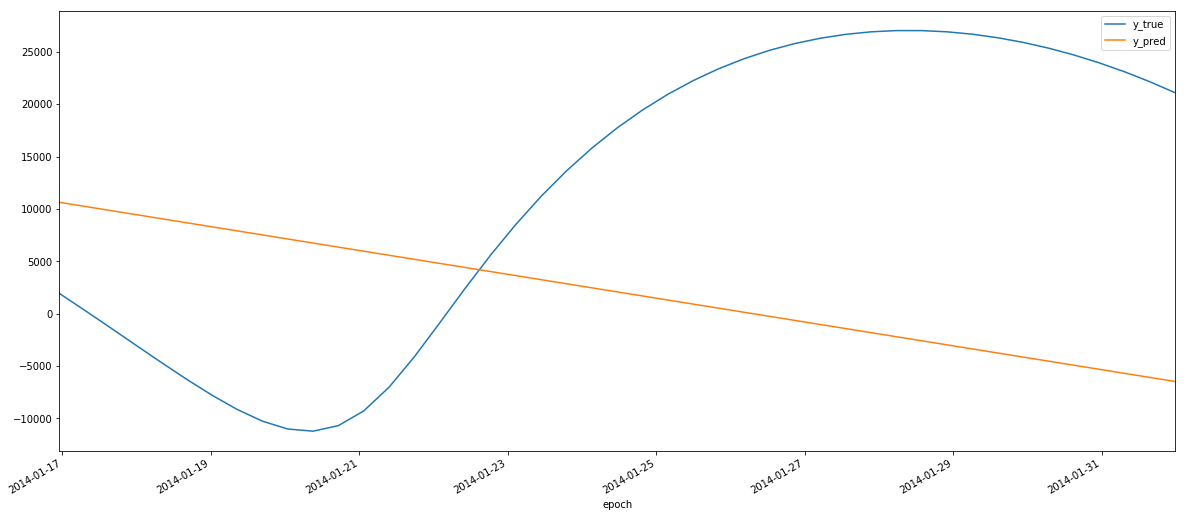

In [43]:
sat_id = 37
cycle_index = 17
target = 'y'
preds.query('sat_id == @sat_id and target == @target and cycle_index == @cycle_index').plot(x='epoch', y=['y_true', 'y_pred'], figsize=(20, 9));

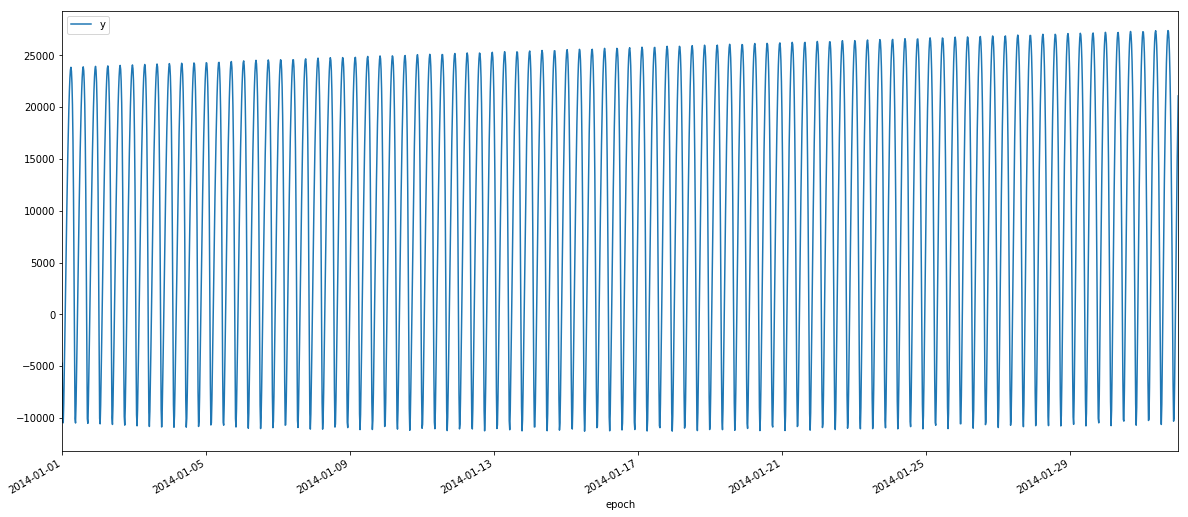

In [44]:
data.query(f'is_train and sat_id == @sat_id').plot(x='epoch', y=[target], figsize=(20, 9));

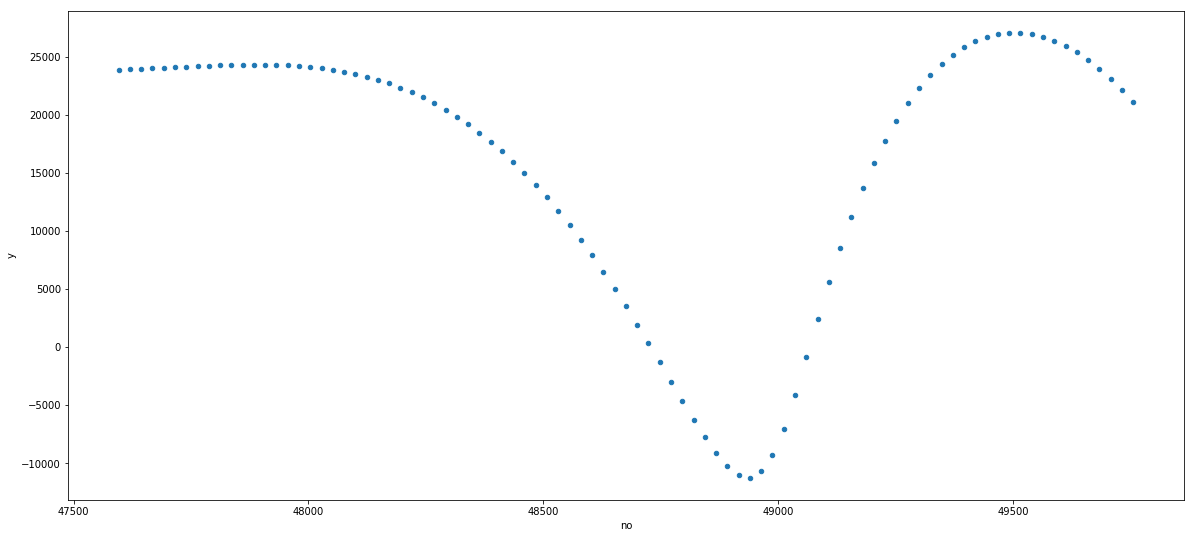

In [45]:
data['no'] = range(len(data))
data.query(f'is_train and sat_id == @sat_id and cycle_index == @cycle_index').plot(x='no', y=target, kind='scatter', figsize=(20, 9));

In [46]:
for col in ('x', 'y', 'z', 'Vx', 'Vy', 'Vz'):
    data[f'{col}_prev'] = data.groupby('sat_id')[col].shift(24)
    data[f'{col}_err'] = data[col] - data[f'{col}_prev']

In [47]:
#for (sat, idx), g in data.groupby(['sat_id', 'cycle_index']):
#    print(sat, idx, g['x'].corr(g['x'].shift(24), method='kendall'))

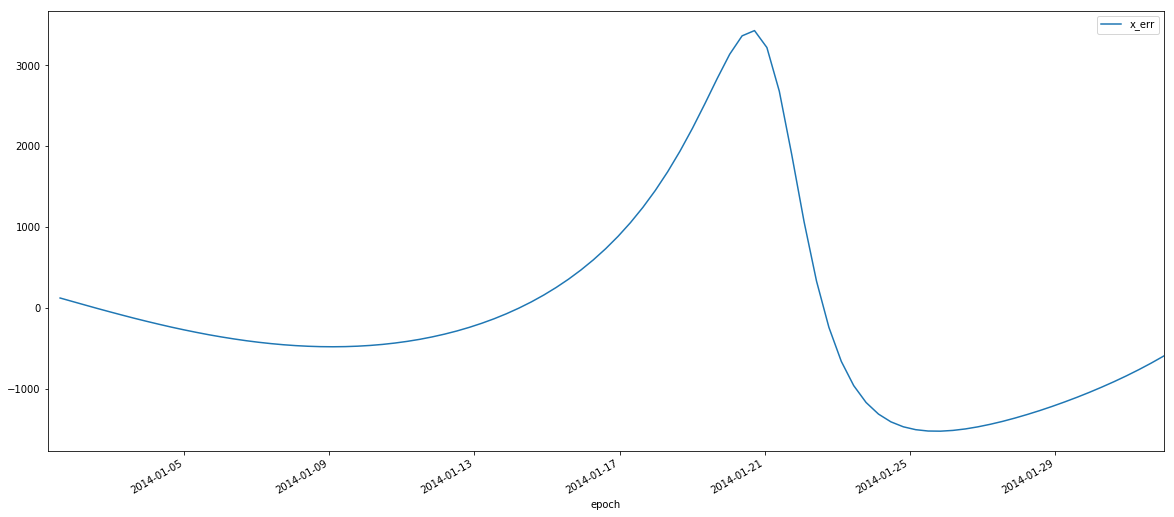

In [48]:
d = data.query(f'is_train and sat_id == @sat_id and cycle_index == @cycle_index').copy()
d.plot(x='epoch', y='x_err', figsize=(20, 9))

In [51]:
x = pd.Series([1, 2, 3, 2, 1, 2, 3, 2, 1])
(x > x.shift()) & (x > x.shift(-1))

0    False
1    False
2     True
3    False
4    False
5    False
6     True
7    False
8    False
dtype: bool

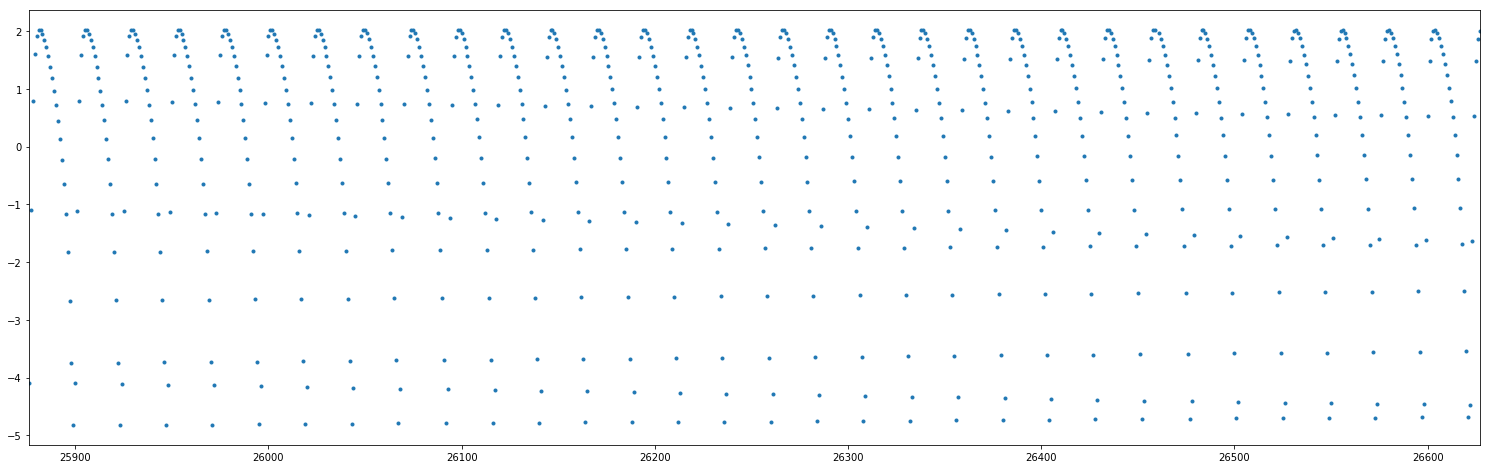

In [111]:
import matplotlib.pyplot as plt

d = data.query(f'is_train and sat_id == 25').copy()
d['Vx'].plot(style='.', figsize=(26, 8));

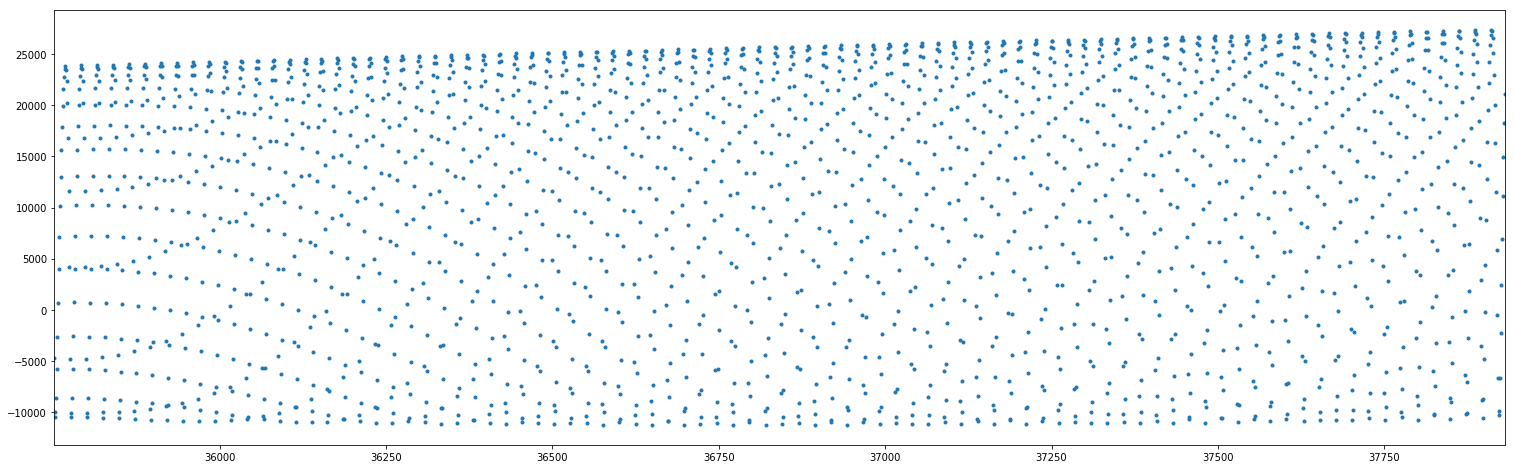

In [113]:
d = data.query(f'is_train and sat_id == @sat_id').copy()
d['y'].plot(style='.', figsize=(26, 8));

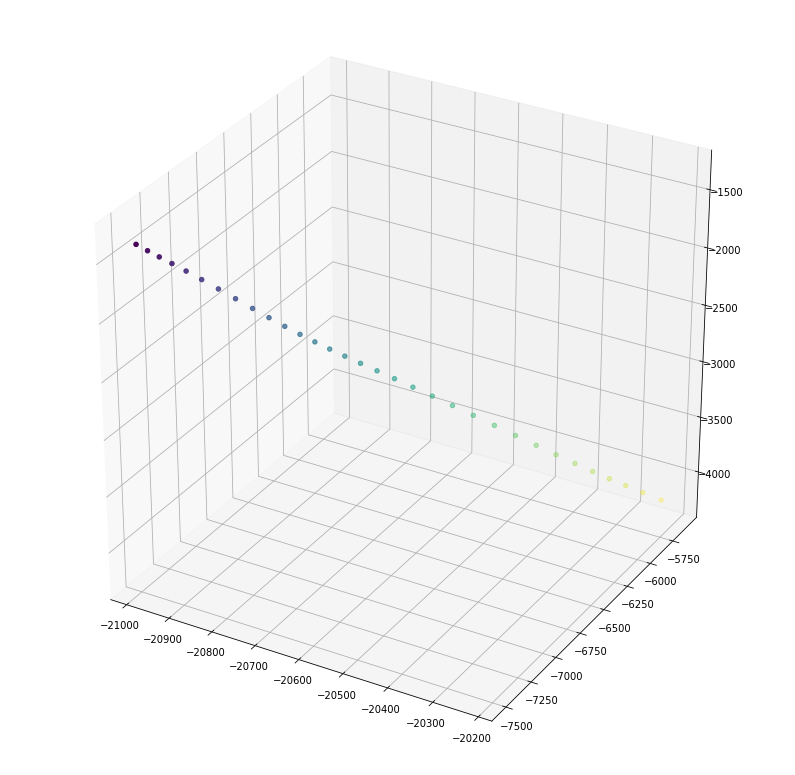

In [109]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111, projection='3d')

d = data.query(f'is_train and sat_id == 25 and cycle_index == 1').copy()

ax.scatter(xs=d['x'], ys=d['y'], zs=d['z'], c=d['no'])
plt.savefig('sat_25_idx_1.png')

In [ ]:
37     0.781003
372    0.770408
249    0.725060
587    0.723423
523    0.694726
514    0.673835
473    0.599283
253    0.537392
429    0.511100
478    0.492735

In [ ]:
sat_id
108    0.000180
419    0.000226
337    0.000236
382    0.000307
400    0.000334
0      0.000395
67     0.000440
286    0.000443
579    0.000443
94     0.000452

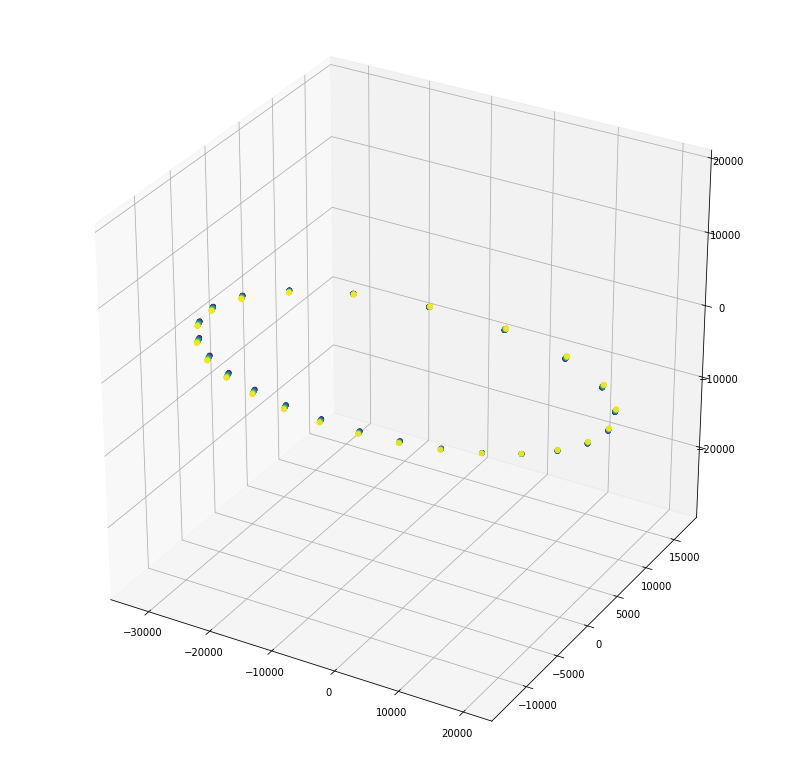

In [138]:
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111, projection='3d')

d = data.query(f'is_train and sat_id == 94').copy()

ax.scatter(xs=d['x'], ys=d['y'], zs=d['z'], c=d['no'])
plt.savefig('sat_37_idx_1.png')

In [77]:
d['y']

35751    -4716.124093
35752   -10034.734578
35753   -10462.630158
35754    -8602.292516
35755    -5800.696706
             ...     
37927     6926.045123
37928    11127.900350
37929    14917.291779
37930    18249.056819
37931    21096.972542
Name: y, Length: 2178, dtype: float64

In [73]:
x = d['y']
d['peak'] = (x > x.shift()) & (x > x.shift(-1))
#for i, (_, r) in enumerate(d.iterrows()):
#    print(i, r['peak'], r['cycle_index'], r['cycle_no'])

In [55]:
d = data.query(f'is_train and sat_id == @sat_id').copy()
#d = data.query(f'is_train and sat_id == @sat_id and cycle_index == @cycle_index').copy()
d['epoch_diff'] = d['epoch'].diff()

i = 0
for _, row in d.iterrows():
    if i != row['cycle_no']:
        i = row['cycle_no']
        print()
    print(row['cycle_no'], row['cycle_index'], row['epoch'], '-', row['epoch_diff'], row['y'], row['y_prev'], row['y_err'])

0 0 2014-01-01 00:00:00 - NaT -4716.1240932704995 nan nan
0 1 2014-01-01 00:20:30.131000 - 0 days 00:20:30.131000 -10034.734577964193 nan nan
0 2 2014-01-01 00:41:00.263000 - 0 days 00:20:30.132000 -10462.63015813195 nan nan
0 3 2014-01-01 01:01:30.394000 - 0 days 00:20:30.131000 -8602.292515670166 nan nan
0 4 2014-01-01 01:22:00.526000 - 0 days 00:20:30.132000 -5800.696706389144 nan nan
0 5 2014-01-01 01:42:30.657000 - 0 days 00:20:30.131000 -2615.868455829744 nan nan
0 6 2014-01-01 02:03:00.788000 - 0 days 00:20:30.131000 691.0583673303685 nan nan
0 7 2014-01-01 02:23:30.920000 - 0 days 00:20:30.132000 3980.3057424605827 nan nan
0 8 2014-01-01 02:44:01.051000 - 0 days 00:20:30.131000 7167.4475418884585 nan nan
0 9 2014-01-01 03:04:31.183000 - 0 days 00:20:30.132000 10195.26834532646 nan nan
0 10 2014-01-01 03:25:01.314000 - 0 days 00:20:30.131000 13020.256485530772 nan nan
0 11 2014-01-01 03:45:31.446000 - 0 days 00:20:30.132000 15605.33392881301 nan nan
0 12 2014-01-01 04:06:01.5770